In [1]:
import torch
import torch.nn as nn
from torch.optim import SGD
import math
import numpy as np

In [2]:
torch.manual_seed(1017)
dtype = torch.float32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda:0


In [3]:
import random
import datetime
import numpy
import pandas as pd

class FXDiffBoaderDataset:
    def __init__(self, isTraining = True, seed=0, mode="default"):
        random.seed(seed)
        rates = pd.read_csv('/mnt/landisk/data/fx/NextBoaderPossibility/fx_USDJPY_5_2020-08-03T23-05-00_to_2021-12-04T07-50-00.csv', header=0, index_col=0, parse_dates=True)
        diff_array = rates.iloc[1:].values - rates.iloc[0:-1].values
        data = pd.DataFrame(diff_array, columns=['time', 'open', 'high', 'low', 'close', 'tick_volume', 'spread', 'real_volume'])
        data = data.drop(columns=['time', 'real_volume'])
        data.tick_volume = rates.tick_volume
        data.spread = rates.spread
        rollingWindow = 10
        boaders, nan_index_head, nan_index_last = self.BoaderValueDiff(rates, rollingWindow, False)
        data["BoaderValue"] = boaders[1:]
        print(f"{nan_index_head} to {nan_index_last}")
        self.all_data = data[nan_index_head:nan_index_last]
        length = len(self.all_data)
        print(length)
            
        self.dataRange = datetime.timedelta(days=2)
        self.dims = 5
        self.mode = mode
        INTERVAL_DAYS = 2
        MINUTES_SPAN = 5

        totalMinutes = INTERVAL_DAYS * 24 * 60
        self.span  = int(totalMinutes/MINUTES_SPAN)+1
        
        ##select random indices.
        self.indices = random.sample(range(0, length - self.span -1), k=length - self.span -1)
        if isTraining:
            self.fromIndex = 0
            self.toIndex = int(length*0.7)
        else:
            self.fromIndex = int(length*0.7)+1
            self.toIndex = length+1
        
        if self.mode == "nrate":
            self.outputFunc = self.__getNormalizedAnsRates__
        elif self.mode == "default":
            self.outputFunc = self.__getAnsRates__
        elif self.mode == "array":
            self.outputFunc = self.__getAnsArray__
            
    def __getDiffArray__(self, data):
        for i in range(1,len(data)):
            data[i] - data[i-1]
        
    def __rateToArray__(self, value):
        output = [0 for i in range(0,3000)]
        i = round((value -0.85)*10000)
        if i >= 3000:
            i = 2999
        elif i < 0:
            i = 0
        output[i] = 1
        return output
        
    def __len__(self):
        return self.toIndex - self.fromIndex
    
    def __getAnsRates__(self,ndx):
        ans = []
        if type(ndx) == slice:
            for index in self.indices[ndx]:
                currentValue = self.all_data['close'].iloc[index]
                ans.append([currentValue - self.all_data['BoaderValue'].iloc[index]])
        else:
            index = ndx
            currentValue = self.all_data['close'].iloc[index]
            ans = [currentValue - self.all_data['BoaderValue'].iloc[index]]
        return ans
    
    def __getNormalizedAnsRates__(self,ndx):
        ans = []
        if type(ndx) == slice:
            for index in self.indices[ndx]:
                maxValue = self.all_data['high'].iloc[index:index+self.span].values.max()
                ans.append(self.all_data['BoaderValue'].iloc[index]/maxValue)
        else:
            index = ndx
            maxValue = self.all_data['high'].iloc[index:index+self.span].values.max()
            ans = [self.all_data['BoaderValue'].iloc[index]/maxValue]
        return ans
    
    def __getAnsArray__(self, ndx):
        ans = []
        for value in self.__getNormalizedAnsRates__(ndx):
            ans.append(
                self.__rateToArray__(value)
            )
        return ans
    
    def __getInputs__(self, ndx):
        inputs = []
        data = self.all_data.drop(columns='BoaderValue')
        if type(ndx) == slice:
            for index in self.indices[ndx]:
                inputs.append(data[index:index+self.span].values.tolist())
        else:
            index = ndx
            inputs = data[index:index+self.span].values.tolist()

        return inputs
    
    def BoaderValueDiff(self, rates, frame, removeNan=True):
        def updateNextBoaders(start, end, value, previouseValue):
            if previouseValue != -1:
                for i in range(start, end+1):
                    nextBoaders.append(value - previouseValue)
                
                return 0
            else:
                for i in range(start, end+1):
                    nextBoaders.append(numpy.NaN)
                return end - start

        data = rates.copy()
        ma = data.close.rolling(frame).mean()
        if ma[frame-1] == numpy.NaN:
            print("invalid")
            return None
        data["EMA"] = ma
        initial = frame
        startIndex = initial
        lastNanIndex = initial
        nextBoaders = [numpy.NaN for i in range(0,initial)]
        trend = 0
        previouseValue = -1

        for index in range(initial, len(data)):
            diff = data.EMA[index-1] - data.EMA[index]
            if diff >= 0:
                if trend == -1:
                    lastNanIndex += updateNextBoaders(startIndex, index, data.EMA[index], previouseValue)
                    startIndex = index+1
                    previouseValue = data.EMA[index]
                trend = 1
            else:
                if trend == 1:
                    lastNanIndex += updateNextBoaders(startIndex, index, data.EMA[index], previouseValue)
                    startIndex = index+1
                    previouseValue = data.EMA[index]
                trend = -1
                

        updateNextBoaders(startIndex, len(data)-1, numpy.NaN, numpy.NaN)
        result = len(data) == len(nextBoaders)
        print(f"Result:{result}")
        if result:
            if removeNan:
                return nextBoaders[lastNanIndex:startIndex]
            else:
                return nextBoaders, lastNanIndex, startIndex
        else:
            print(f"{len(data)} !== {len(nextBoaders)}")
    
    def __getitem__(self, ndx):
        ins = numpy.array(self.__getInputs__(ndx), dtype=numpy.dtype('float32'))
        outputs = numpy.array(self.outputFunc(ndx), dtype=numpy.dtype('float32'))
        return torch.tensor(ins, device=device).to(dtype=dtype), torch.tensor(outputs, device=device).to(dtype=dtype)
        return ins, outputs
    
    def changeMode(self, mode):
        self.mode = mode
        if self.mode == "nrate":
            self.outputFunc = self.__getNormalizedAnsRates__
        elif self.mode == "default":
            self.outputFunc = self.__getAnsRates__
        elif self.mode == "array":
            self.outputFunc = self.__getAnsArray__

In [4]:
import torch
import torch.nn as nn
from torch.optim import SGD
import math
import numpy as np

class Predictor(nn.Module):
    def __init__(self, inputDim, hiddenDim, outputDim):
        super(Predictor, self).__init__()

        self.rnn = nn.LSTM(input_size = inputDim,
                            hidden_size = hiddenDim,
                            batch_first = True)
        self.rnn.to(device)
        self.output_layer = nn.Linear(hiddenDim, outputDim)
        self.output_layer.to(device)
    
    def forward(self, inputs, hidden0=None):
        batch_size, seq_len = inputs.shape[0], inputs.shape[1]
        output, (hidden, cell) = self.rnn(inputs, hidden0) #LSTM層
        output = self.output_layer(output[:, -1, :]) #全結合層

        return output

In [66]:
#train_x, train_t = mkDataSet(training_size) #Datasetの作成
train_ds = FXDiffBoaderDataset(True, 1017)

model = Predictor(6, hidden_size, 1) #modelの宣言

criterion = nn.MSELoss() #評価関数の宣言
optimizer = SGD(model.parameters(), lr=0.0001) #最適化関数の宣言

Result:True
35 to 99921
99886


In [55]:
training_size = 1000 #traning dataのデータ数
epochs_num = 10000 #traningのepoch回数
hidden_size = 5 #LSTMの隠れ層の次元数
batch_size = 1000

In [50]:
i,o = train_ds[0:1]

In [51]:
i.shape

torch.Size([1, 577, 6])

In [56]:
for epoch in range(epochs_num):
    # training
    running_loss = 0.0
    training_accuracy = 0.0
    first = np.random.randint(0, len(train_ds) - training_size)
    for i in range(first, first+training_size):
        optimizer.zero_grad()
        data, label = train_ds[i:i+1]

        output = model(data)

        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.data.item()
        #training_accuracy += np.sum(np.abs((output.data - label.data).numpy()) < 0.1) #outputとlabelの誤差が0.1以内なら正しいとみなす。
    #training_accuracy /= training_size
    print('%d loss: %.3f' % (epoch + 1, running_loss/training_size))

1 loss: 30.513
2 loss: 26.053
3 loss: 21.023
4 loss: 24.594
5 loss: 21.635
6 loss: 22.524
7 loss: 22.531
8 loss: 21.650
9 loss: 24.639
10 loss: 21.876
11 loss: 20.371
12 loss: 21.911
13 loss: 20.538
14 loss: 19.105
15 loss: 19.457
16 loss: 21.465
17 loss: 15.784
18 loss: 17.623
19 loss: 19.015
20 loss: 22.245
21 loss: 23.396
22 loss: 19.804
23 loss: 20.763
24 loss: 18.866
25 loss: 15.586
26 loss: 19.514
27 loss: 20.530
28 loss: 16.597
29 loss: 19.036
30 loss: 20.792
31 loss: 21.347


KeyboardInterrupt: 

In [74]:
training_size = 10000 #traning dataのデータ数
epochs_num = 20000 #traningのepoch回数
hidden_size = 50 #LSTMの隠れ層の次元数
batch_size = 100

In [59]:
data, label = train_ds[i:i+batch_size]

In [61]:
label.shape

torch.Size([100])

In [75]:
epochs_num = 1000
optimizer = SGD(model.parameters(), lr=0.0001) #最適化関数の宣言

<IPython.core.display.Javascript object>


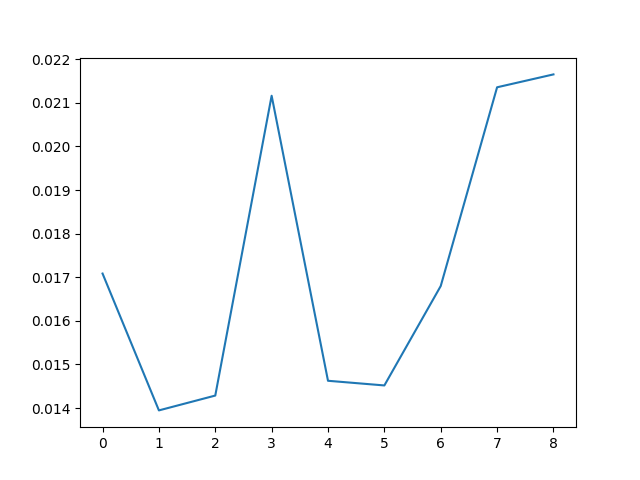

2021-12-26 12:46:51.455422: 1 loss: 0.01708413234911859
2021-12-26 12:47:09.126236: 2 loss: 0.01394578610546887


KeyboardInterrupt: 

In [76]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import random

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
losses = []

for epoch in range(epochs_num):
    
    # training
    running_loss = 0.0
    training_accuracy = 0.0
    first = np.random.randint(0, len(train_ds) - training_size)
    batch_training_size= int(training_size / batch_size)
    for i in range(first, first+batch_training_size):
        optimizer.zero_grad()

        data, label = train_ds[i:i+batch_size]

        output = model(data)

        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.data.item()
    losses.append(running_loss/batch_training_size)
    ax.clear()
    ax.plot(losses)
    fig.canvas.draw()
    ax.clear()
    ax.plot(losses)
    fig.canvas.draw()
    if epoch == 1 or epoch % 10 == 0:
        print(f'{datetime.datetime.now()}: {epoch + 1} loss: {running_loss/batch_training_size}')

In [27]:
#test
test_accuracy = 0.0
test_size = 1000
test_x, test_t = mkDataSet(test_size)

for i in range(int(test_size / batch_size)):
    offset = i * batch_size
    data, label = torch.tensor(test_x[offset:offset+batch_size]), torch.tensor(test_t[offset:offset+batch_size])
    output = model(data, None)

    test_accuracy += np.sum(np.abs((output.data - label.data).numpy()) < 0.1)

training_accuracy /= training_size
test_accuracy /= test_size

print('%d loss: %.3f, training_accuracy: %.5f, test_accuracy: %.5f' % (
    epoch + 1, running_loss, training_accuracy, test_accuracy))

1000 loss: 0.008, training_accuracy: 0.01000, test_accuracy: 1.00000


In [79]:
from torch.utils.data import DataLoader
batch_size = 100
dataloader = DataLoader(train_ds, batch_size=batch_size)

In [88]:
training_size = 10000 #traning dataのデータ数
epochs_num = 100 #traningのepoch回数
hidden_size = 50 #LSTMの隠れ層の次元数

In [81]:
model = Predictor(6, hidden_size, 1) #modelの宣言

In [86]:
criterion = nn.MSELoss() #評価関数の宣言
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

<IPython.core.display.Javascript object>


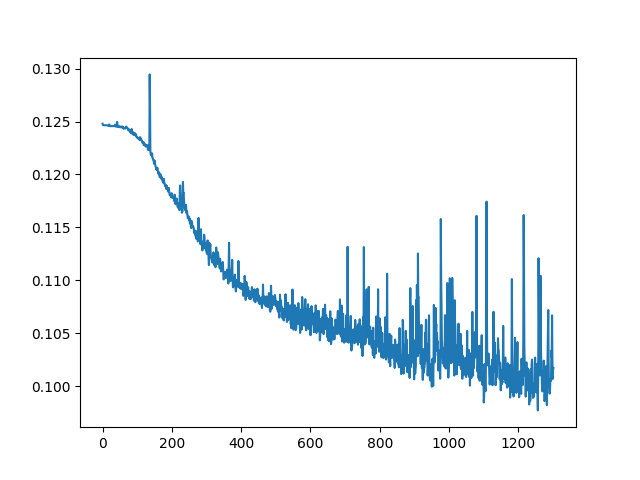

2021-12-26 13:43:01.204976: 1 loss: 0.12479899945319631
2021-12-26 13:47:48.102892: 2 loss: 0.1246859252511058
2021-12-26 14:34:34.911186: 11 loss: 0.12465310402651085
2021-12-26 15:26:49.178383: 21 loss: 0.12472017217543907
2021-12-26 16:19:02.231031: 31 loss: 0.12458676813563216
2021-12-26 17:12:49.885420: 41 loss: 0.12455927494127536
2021-12-26 18:03:33.684175: 51 loss: 0.1244692914497864
2021-12-26 18:50:55.719170: 61 loss: 0.12434420311939903
2021-12-26 19:39:00.681790: 71 loss: 0.12441144481941592
2021-12-26 20:25:58.168560: 81 loss: 0.1239713075729378
2021-12-26 21:13:05.043842: 91 loss: 0.12372575637564295
2021-12-26 21:58:41.340625: 101 loss: 0.12350962994227302
2021-12-26 22:43:07.441890: 111 loss: 0.12335780092995265
2021-12-26 23:33:03.162561: 121 loss: 0.12299212684258237
2021-12-27 00:25:02.669216: 131 loss: 0.12256330559961498
2021-12-27 01:11:56.449039: 141 loss: 0.12185091145132901
2021-12-27 01:54:55.685775: 151 loss: 0.12132529913069448
2021-12-27 02:37:52.418962: 16

KeyboardInterrupt: 

In [87]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import random

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
losses = []

for epoch in range(epochs_num):
    
    # training
    running_loss = 0.0
    training_accuracy = 0.0
    first = np.random.randint(0, len(train_ds) - training_size)
    batch_training_size= int(training_size / batch_size)
    for data, label in dataloader:

        output = model(data)

        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.data.item()
    losses.append(running_loss/batch_training_size)
    ax.clear()
    ax.plot(losses)
    fig.canvas.draw()
    ax.clear()
    ax.plot(losses)
    fig.canvas.draw()
    if epoch == 1 or epoch % 10 == 0:
        print(f'{datetime.datetime.now()}: {epoch + 1} loss: {running_loss/batch_training_size}')

In [89]:
torch.save(model.state_dict(), 'fx_DiffBoaderLSTM_5_2days_mse_v1')

In [350]:
import random
import datetime
import numpy
import pandas as pd

class FXNextDiffBoaderDataset:
    def __init__(self, isTraining = True, seed=0, mode="default"):
        random.seed(seed)
        rates = pd.read_csv('/mnt/landisk/data/fx/NextBoaderPossibility/fx_USDJPY_5_2020-08-03T23-05-00_to_2021-12-04T07-50-00.csv', header=0, index_col=0, parse_dates=True)
        self.rowdata = rates
        diff_array = rates.diff()
        data = pd.DataFrame(diff_array, columns=['time', 'open', 'high', 'low', 'close', 'tick_volume', 'spread', 'real_volume'])
        data = data.drop(columns=['time', 'real_volume'])
        data.tick_volume, _, _ = self.minmaxNormalization(rates.tick_volume)
        data.spread,_,_ = self.minmaxNormalization(rates.spread)
        rollingWindow = 10
        boaders, nan_index_head, nan_index_last = self.BoaderValueDiff(rates, rollingWindow, False)
        self.rowdata["BoaderValue"] = boaders
        data["BoaderValue"], self.ansmin, self.ansmax = self.minmaxNormalization(boaders)
        print(f"{nan_index_head} to {nan_index_last}")
        self.all_data = data[nan_index_head:nan_index_last]
        length = len(self.all_data)
        print(length)
            
        self.dataRange = datetime.timedelta(days=2)
        self.dims = 5
        self.mode = mode
        INTERVAL_DAYS = 2
        MINUTES_SPAN = 5

        totalMinutes = INTERVAL_DAYS * 24 * 60
        self.span  = int(totalMinutes/MINUTES_SPAN)+1
        
        ##select random indices.
        self.indices = random.sample(range(self.span, length - self.span -1), k=length - self.span*2 -1)
        if isTraining:
            self.fromIndex = self.span
            self.toIndex = int(length*0.7)
        else:
            self.fromIndex = int(length*0.7)+1
            self.toIndex = length+1
        
        if self.mode == "nrate":
            self.outputFunc = self.__getNormalizedAnsRates__
        elif self.mode == "default":
            self.outputFunc = self.__getAns__
        elif self.mode == "array":
            self.outputFunc = self.__getAnsArray__
        elif self.mode == "rate":
            self.outputFunc = self.__getAnsRates__
            
    def __getDiffArray__(self, data):
        for i in range(1,len(data)):
            data[i] - data[i-1]
        
    def __rateToArray__(self, value):
        output = [0 for i in range(0,3000)]
        i = round((value -0.85)*10000)
        if i >= 3000:
            i = 2999
        elif i < 0:
            i = 0
        output[i] = 1
        return output
        
    def __len__(self):
        return self.toIndex - self.fromIndex
    
    def __getAns__(self,ndx):
        ans = []
        if type(ndx) == int:
            indicies = slice(ndx, ndx+1)
        elif type(ndx) == slice:
            indicies = ndx
        for index in self.indices[indicies]:
            ans.append(self.all_data['BoaderValue'][index])
        return ans
    
    def __getAnsRates__(self,ndx):
        ans = []
        if type(ndx) == slice:
            for index in self.indices[ndx]:
                currentValue = self.all_data['close'].iloc[index]
                ans.append([currentValue - self.all_data['BoaderValue'].iloc[index]])
        else:
            index = ndx
            currentValue = self.all_data['close'].iloc[index]
            ans = [currentValue - self.all_data['BoaderValue'].iloc[index]]
        return ans
    
    def __getNormalizedAnsRates__(self,ndx):
        ans = []
        if type(ndx) == slice:
            for index in self.indices[ndx]:
                maxValue = self.all_data['high'].iloc[index:index+self.span].values.max()
                ans.append(self.all_data['BoaderValue'].iloc[index]/maxValue)
        else:
            index = ndx
            maxValue = self.all_data['high'].iloc[index:index+self.span].values.max()
            ans = [self.all_data['BoaderValue'].iloc[index]/maxValue]
        return ans
    
    def __getAnsArray__(self, ndx):
        ans = []
        for value in self.__getNormalizedAnsRates__(ndx):
            ans.append(
                self.__rateToArray__(value)
            )
        return ans
    
    def __getRowData__(self, ndx):
        inputs = []
        if type(ndx) == slice:
            for index in self.indices[ndx]:
                inputs.append(self.rowdata[index+1-self.span:index+1].values.tolist())
        else:
            index = ndx
            inputs = self.rowdata[index+1-self.span:index+1].values.tolist()

        return inputs
    
    def __getInputs__(self, ndx):
        inputs = []
        data = self.all_data.drop(columns='BoaderValue')
        if type(ndx) == int:
            indicies = slice(ndx, ndx+1)
            for index in self.indices[indicies]:
                inputs.append(data[index+1-self.span:index+1].values.tolist())
            return inputs[0]
        elif type(ndx) == slice:
            indicies = ndx
            for index in self.indices[indicies]:
                inputs.append(data[index+1-self.span:index+1].values.tolist())
            return inputs
    
    def __getActialIndex__(self,ndx):
        inputs = []
        if type(ndx) == slice:
            for index in self.indices[ndx]:
                inputs.append(index)
        else:
            inputs = self.indices[ndx]

        return inputs
    
    def BoaderValueDiff(self, rates, frame, removeNan=True):
        def updateNextBoaders(start, end, value, previouseValue):
            if previouseValue != -1:
                for i in range(start, end+1):
                    nextBoaders.append(value - previouseValue)
                return 0
            else:
                for i in range(start, end+1):
                    nextBoaders.append(numpy.NaN)
                return end - start

        data = rates.copy()
        ma = data.close.rolling(frame).mean()
        if ma[frame-1] == numpy.NaN:
            print("invalid")
            return None
        data["EMA"] = ma
        initial = frame
        startIndex = initial
        lastNanIndex = initial
        nextBoaders = [numpy.NaN for i in range(0,initial)]
        trend = 0
        previouseValue = -1
        previouseIndex = initial

        for index in range(initial, len(data)):
            diff = data.EMA[index-1] - data.EMA[index]
            if diff >= 0:
                if trend == -1:
                    #lastNanIndex += updateNextBoaders(startIndex, index, data.EMA[index], previouseValue)
                    for i in range(previouseIndex, index):
                        nextBoaders.append(data.EMA[index] - data.close[i])
                    #startIndex = index+1
                    previouseValue = data.EMA[index]
                    previouseIndex = index
                trend = 1
            else:
                if trend == 1:
                    #lastNanIndex += updateNextBoaders(startIndex, index, data.EMA[index], previouseValue)
                    for i in range(previouseIndex, index):
                        nextBoaders.append(data.EMA[index] - data.close[i])
                    #startIndex = index+1
                    previouseValue = data.EMA[index]
                    previouseIndex = index
                trend = -1

        updateNextBoaders(previouseIndex, len(data)-1, numpy.NaN, numpy.NaN)
        result = len(data) == len(nextBoaders)
        print(f"Result:{result}")
        if result:
            if removeNan:
                return numpy.array(nextBoaders[lastNanIndex:previouseIndex])
            else:
                return numpy.array(nextBoaders), lastNanIndex, previouseIndex
        else:
            print(f"{len(data)} !== {len(nextBoaders)}")
    
    def __getitem__(self, ndx):
        ins = numpy.array(self.__getInputs__(ndx), dtype=numpy.dtype('float32'))
        outputs = numpy.array(self.outputFunc(ndx), dtype=numpy.dtype('float32'))
        return torch.tensor(ins, device=device).to(dtype=dtype), torch.tensor(outputs, device=device).to(dtype=dtype)
        #return ins, outputs
    
    def changeMode(self, mode):
        self.mode = mode
        if self.mode == "nrate":
            self.outputFunc = self.__getNormalizedAnsRates__
        elif self.mode == "default":
            self.outputFunc = self.__getAnsRates__
        elif self.mode == "array":
            self.outputFunc = self.__getAnsArray__
    
    def minmaxNormalization(self, data):
        if type(data) == numpy.ndarray:
            temp_data = data[~numpy.isnan(data)]
        elif type(data) == pd.core.series.Series:
            temp_data = data.dropna()
        else:
            print(f"unkown type: {type(data)}")
            temp_data = data
        X_max, X_min = max(temp_data), min(temp_data)
        data_norm = (data - X_min) / (X_max - X_min)
        return data_norm, X_min, X_max

    def convertAnsToBoaderValue(self,rate):
        ansValue = rate*(self.ansmax - self.ansmin) + self.ansmin
        return ansValue

In [351]:
train_ds = FXNextDiffBoaderDataset(True, 1017)

Result:True
10 to 99920
99910


In [354]:
from torch.utils.data import DataLoader
batch_size = 64
dataloader = DataLoader(train_ds, batch_size=batch_size)

In [367]:
training_size = 10000 #traning dataのデータ数
epochs_num = 500 #traningのepoch回数
hidden_size = 50 #LSTMの隠れ層の次元数

In [352]:
i,o = train_ds[0]

In [353]:
i.shape

torch.Size([577, 6])

In [346]:
model = Predictor(6, hidden_size, 1) #modelの宣言

In [366]:
criterion = nn.MSELoss() #評価関数の宣言
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

<IPython.core.display.Javascript object>


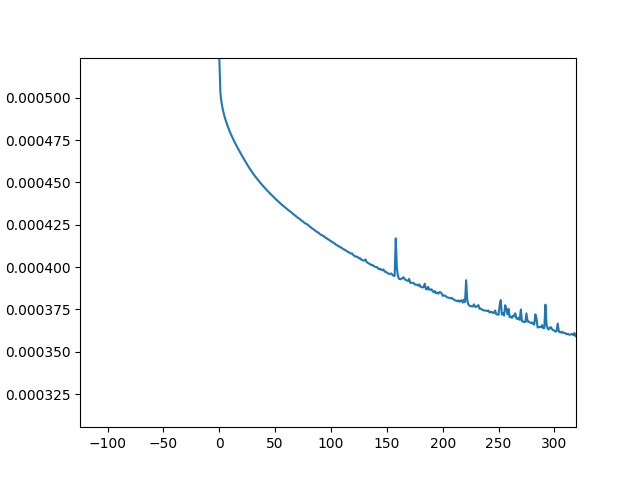

2021-12-31 14:03:44.186029: 1 loss: 0.0005234664343520424
2021-12-31 14:08:50.687323: 2 loss: 0.000502752826821215
2021-12-31 14:49:49.183994: 11 loss: 0.00047911958863084856
2021-12-31 15:36:00.832486: 21 loss: 0.0004661949513040152
2021-12-31 16:27:02.125547: 31 loss: 0.0004554994379526388
2021-12-31 17:20:58.328413: 41 loss: 0.0004473294643619925
2021-12-31 18:07:13.276131: 51 loss: 0.00044052389606664434
2021-12-31 18:53:04.959083: 61 loss: 0.00043460058332829457
2021-12-31 19:38:55.003984: 71 loss: 0.00042934473218244815
2021-12-31 20:24:44.356723: 81 loss: 0.0004245092788481158
2021-12-31 21:10:34.021237: 91 loss: 0.00041959287227655295
2021-12-31 21:56:26.966997: 101 loss: 0.00041540771384554833
2021-12-31 22:42:21.038321: 111 loss: 0.0004111134957826998
2021-12-31 23:30:29.965696: 121 loss: 0.00040713955933405
2022-01-01 00:19:36.747076: 131 loss: 0.0004039776106018951
2022-01-01 01:07:29.335303: 141 loss: 0.00040003941939385887
2022-01-01 01:53:54.390045: 151 loss: 0.000396841

KeyboardInterrupt: 

In [368]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import random

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
losses = []

for epoch in range(epochs_num):
    
    # training
    running_loss = 0.0
    training_accuracy = 0.0
    first = np.random.randint(0, len(train_ds) - training_size)
    batch_training_size= int(training_size / batch_size)
    for data, label in dataloader:
        output = model(data)

        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.data.item()
    losses.append(running_loss/batch_training_size)
    ax.clear()
    ax.plot(losses)
    fig.canvas.draw()
    ax.clear()
    ax.plot(losses)
    fig.canvas.draw()
    if epoch == 1 or epoch % 10 == 0:
        print(f'{datetime.datetime.now()}: {epoch + 1} loss: {running_loss/batch_training_size}')

In [370]:
torch.save(model.state_dict(), 'fx_DiffNextBoaderLSTM_5_2days_mse_v2')

In [364]:
dummy_input, dummy_output = train_ds[0:1]

In [365]:
dummy_input, dummy_output = train_ds[0:1]
torch.onnx.export(model, dummy_input, 'fx_DiffNextBoaderLSTM_5_2days_mse_v2.onnx')

In [363]:
dummy_input.shape

torch.Size([577, 6])

１足分先のOHLHの予測

In [1]:
import random
import datetime
import numpy
import pandas as pd
import torch

torch.manual_seed(1017)
dtype = torch.float32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

class FXNextOHLCDiffDataset:
    def __init__(self, isTraining = True, seed=0, mode="default"):
        random.seed(seed)
        rates = pd.read_csv('/mnt/landisk/data/fx/NextBoaderPossibility/fx_USDJPY_5_2020-08-03T23-05-00_to_2021-12-04T07-50-00.csv', header=0, index_col=0, parse_dates=True)
        self.rowdata = rates
        diff_array = rates.diff().dropna()
        data = pd.DataFrame(diff_array, columns=['time', 'open', 'high', 'low', 'close', 'tick_volume', 'spread', 'real_volume'])
        data = data.drop(columns=['time', 'real_volume'])
        data.tick_volume, _, _ = self.minmaxNormalization(rates.tick_volume)
        data.spread,_,_ = self.minmaxNormalization(rates.spread)
        self.all_data = data
        length = len(self.all_data)
        print(length)
            
        self.dataRange = datetime.timedelta(days=2)
        self.dims = 5
        self.mode = mode
        INTERVAL_DAYS = 2
        MINUTES_SPAN = 5

        totalMinutes = INTERVAL_DAYS * 24 * 60
        self.span  = int(totalMinutes/MINUTES_SPAN)+1
        
        ##select random indices.
        self.indices = random.sample(range(self.span, length - self.span -1), k=length - self.span*2 -1)
        if isTraining:
            self.fromIndex = self.span
            self.toIndex = int(length*0.7)
        else:
            self.fromIndex = int(length*0.7)+1
            self.toIndex = length+1
        self.outputFunc = self.__getAns__
        
    def __getDiffArray__(self, data):
        for i in range(1,len(data)):
            data[i] - data[i-1]
        
    def __rateToArray__(self, value):
        output = [0 for i in range(0,3000)]
        i = round((value -0.85)*10000)
        if i >= 3000:
            i = 2999
        elif i < 0:
            i = 0
        output[i] = 1
        return output
        
    def __len__(self):
        return self.toIndex - self.fromIndex
    
    def __getAns__(self,ndx):
        ans = []
        if type(ndx) == int:
            indicies = slice(ndx, ndx+1)
            index = self.indices[ndx]
            return self.all_data[['high', 'low']].iloc[index+1].values

        elif type(ndx) == slice:
            indicies = ndx
        for index in self.indices[indicies]:
            ans.append(self.all_data[['high', 'low']].iloc[index+1].values)
        return ans
        
    def __getRowData__(self, ndx):
        inputs = []
        if type(ndx) == slice:
            for index in self.indices[ndx]:
                inputs.append(self.rowdata[index+1-self.span:index+1].values.tolist())
        else:
            index = ndx
            inputs = self.rowdata[index+1-self.span:index+1].values.tolist()

        return inputs
    
    def __getInputs__(self, ndx):
        inputs = []
        data = self.all_data
        if type(ndx) == int:
            indicies = slice(ndx, ndx+1)
            for index in self.indices[indicies]:
                inputs.append(data[index+1-self.span:index+1].values.tolist())
            return inputs[0]
        elif type(ndx) == slice:
            indicies = ndx
            for index in self.indices[indicies]:
                inputs.append(data[index+1-self.span:index+1].values.tolist())
            return inputs
    
    def __getActialIndex__(self,ndx):
        inputs = []
        if type(ndx) == slice:
            for index in self.indices[ndx]:
                inputs.append(index)
        else:
            inputs = self.indices[ndx]

        return inputs
    
    def BoaderValueDiff(self, rates, frame, removeNan=True):
        def updateNextBoaders(start, end, value, previouseValue):
            if previouseValue != -1:
                for i in range(start, end+1):
                    nextBoaders.append(value - previouseValue)
                return 0
            else:
                for i in range(start, end+1):
                    nextBoaders.append(numpy.NaN)
                return end - start

        data = rates.copy()
        ma = data.close.rolling(frame).mean()
        if ma[frame-1] == numpy.NaN:
            print("invalid")
            return None
        data["EMA"] = ma
        initial = frame
        startIndex = initial
        lastNanIndex = initial
        nextBoaders = [numpy.NaN for i in range(0,initial)]
        trend = 0
        previouseValue = -1
        previouseIndex = initial

        for index in range(initial, len(data)):
            diff = data.EMA[index-1] - data.EMA[index]
            if diff >= 0:
                if trend == -1:
                    #lastNanIndex += updateNextBoaders(startIndex, index, data.EMA[index], previouseValue)
                    for i in range(previouseIndex, index):
                        nextBoaders.append(data.EMA[index] - data.close[i])
                    #startIndex = index+1
                    previouseValue = data.EMA[index]
                    previouseIndex = index
                trend = 1
            else:
                if trend == 1:
                    #lastNanIndex += updateNextBoaders(startIndex, index, data.EMA[index], previouseValue)
                    for i in range(previouseIndex, index):
                        nextBoaders.append(data.EMA[index] - data.close[i])
                    #startIndex = index+1
                    previouseValue = data.EMA[index]
                    previouseIndex = index
                trend = -1

        updateNextBoaders(previouseIndex, len(data)-1, numpy.NaN, numpy.NaN)
        result = len(data) == len(nextBoaders)
        print(f"Result:{result}")
        if result:
            if removeNan:
                return numpy.array(nextBoaders[lastNanIndex:previouseIndex])
            else:
                return numpy.array(nextBoaders), lastNanIndex, previouseIndex
        else:
            print(f"{len(data)} !== {len(nextBoaders)}")
    
    def __getitem__(self, ndx):
        ins = numpy.array(self.__getInputs__(ndx), dtype=numpy.dtype('float32'))
        outputs = numpy.array(self.outputFunc(ndx), dtype=numpy.dtype('float32'))
        return torch.tensor(ins, device=device).to(dtype=dtype), torch.tensor(outputs, device=device).to(dtype=dtype)
        #return ins, outputs
    
    def minmaxNormalization(self, data):
        if type(data) == numpy.ndarray:
            temp_data = data[~numpy.isnan(data)]
        elif type(data) == pd.core.series.Series:
            temp_data = data.dropna()
        else:
            print(f"unkown type: {type(data)}")
            temp_data = data
        X_max, X_min = max(temp_data), min(temp_data)
        data_norm = (data - X_min) / (X_max - X_min)
        return data_norm, X_min, X_max

    def convertAnsToBoaderValue(self,rate):
        ansValue = rate*(self.ansmax - self.ansmin) + self.ansmin
        return ansValue

device: cuda:0


In [2]:
ds = FXNextOHLCDiffDataset()

99935


In [3]:
from torch.utils.data import DataLoader
batch_size = 64
dataloader = DataLoader(ds, batch_size=batch_size)

In [4]:
training_size = 10000 #traning dataのデータ数
epochs_num = 500 #traningのepoch回数
hidden_size = 50 #LSTMの隠れ層の次元数

In [5]:
i,o = ds[0]

In [6]:
print(f"input: {i.shape}")
print(f"outut: {o.shape}")

input: torch.Size([577, 6])
outut: torch.Size([2])


In [9]:
model = Predictor(6, hidden_size, 2)

In [16]:
criterion = nn.MSELoss() #評価関数の宣言
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [11]:
def mkRandomBatch(train_x, train_t, batch_size=10):
    """
    train_x, train_tを受け取ってbatch_x, batch_tを返す。
    """
    batch_x = []
    batch_t = []

    for _ in range(batch_size):
        idx = np.random.randint(0, len(train_x) - 1)
        batch_x.append(train_x[idx])
        batch_t.append(train_t[idx])
    
    return torch.tensor(batch_x), torch.tensor(batch_t)

<IPython.core.display.Javascript object>


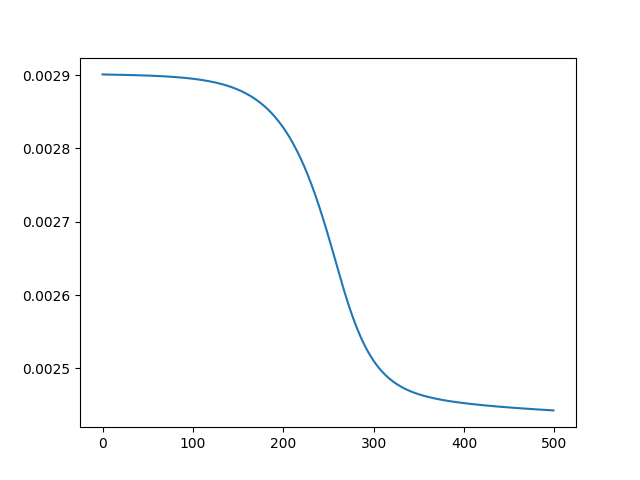

2022-01-04 19:27:39.440381: 1 loss: 0.002900967884507293
2022-01-04 19:31:18.175554: 2 loss: 0.0029008534370055152
2022-01-04 20:02:08.038564: 11 loss: 0.002900664413456793
2022-01-04 20:37:07.642771: 21 loss: 0.002900421652483578
2022-01-04 21:11:35.009272: 31 loss: 0.0029001339037980265
2022-01-04 21:49:02.292885: 41 loss: 0.0028997878799623907
2022-01-04 22:37:05.414327: 51 loss: 0.002899366085376898
2022-01-04 23:25:10.573842: 61 loss: 0.002898845760589607
2022-01-05 00:13:52.723055: 71 loss: 0.002898196929961089
2022-01-05 01:02:18.789588: 81 loss: 0.0028973804316989025
2022-01-05 01:50:11.160356: 91 loss: 0.002896345175031456
2022-01-05 02:37:04.177354: 101 loss: 0.002895025379098698
2022-01-05 03:25:00.107730: 111 loss: 0.0028933342549955854
2022-01-05 04:00:08.647991: 121 loss: 0.002891161522525064
2022-01-05 04:35:30.212816: 131 loss: 0.002888364944877909
2022-01-05 05:11:09.230659: 141 loss: 0.0028847618472448234
2022-01-05 05:47:34.587735: 151 loss: 0.0028801175771943047
202

In [17]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import random

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
losses = []

for epoch in range(epochs_num):
    
    # training
    running_loss = 0.0
    training_accuracy = 0.0
    first = np.random.randint(0, len(ds) - training_size)
    batch_training_size= int(training_size / batch_size)
    for data, label in dataloader:
        output = model(data)

        loss = criterion(output, label)
        #print(f"label: {label.shape}")
        #print(f"outut: {output.shape}")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.data.item()
    losses.append(running_loss/batch_training_size)
    ax.clear()
    ax.plot(losses)
    fig.canvas.draw()
    ax.clear()
    ax.plot(losses)
    fig.canvas.draw()
    if epoch == 1 or epoch % 10 == 0:
        print(f'{datetime.datetime.now()}: {epoch + 1} loss: {running_loss/batch_training_size}')

In [18]:
torch.save(model.state_dict(), 'fx_DiffNextHL_LSTM_5_2days_mse_v1')

In [ ]:
val_ds = FXNextOHLCDiffDataset(False)
val_dl = DataLoader(val_ds, batch_size = batch_size)

In [108]:
%matplotlib notebook
def validate(model, val_loader):
    high_d = 0
    low_d = 0
    out_ = numpy.array([])
    ans_ = numpy.array([])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.ion()

    fig.show()
    fig.canvas.draw()
    losses = []

    for name, loader in [("val", val_loader)]:
        print(name)
        with torch.no_grad():
            correct = 0
            count = 0
            for values, anses in loader:
                outputs = model(values)
                ans = anses
                temp = outputs -ans
                high_d += temp[:,0].mean()
                low_d += temp[:,1].mean()
                out_ = numpy.append(out_, outputs[:,1].to('cpu').detach().numpy().copy())
                ans_ = numpy.append(ans_, ans[:,1].to('cpu').detach().numpy().copy())
                #high_rates = numpy.append(high_rates, rates[:,0].to('cpu').detach().numpy().copy())
                #low_rates = numpy.append(low_rates, rates[:,1].to('cpu').detach().numpy().copy())
                count += 1
    print('--------------------------------------------------')
    print(f'high: {high_d/count}, low:{low_d/count}')
    print('--------------------------------------------------')
    ax.clear()
    ax.plot(ans_,out_, 'ro', color="red")
    fig.canvas.draw()

<IPython.core.display.Javascript object>


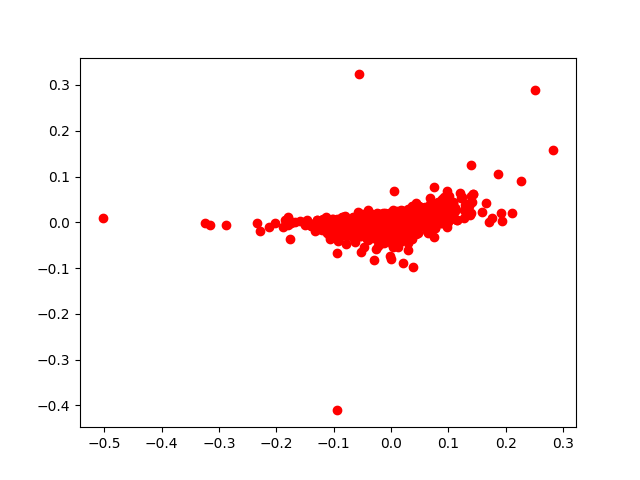

val
--------------------------------------------------
high: 4.258924491296057e-06, low:-3.771047340705991e-05
--------------------------------------------------


In [109]:
validate(model, val_dl)

In [2]:
import random
import datetime
import numpy
import pandas as pd
import torch

torch.manual_seed(1017)
dtype = torch.float32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

class FXNextMEANDiffDataset:
    def __init__(self,short_window=12, long_window=26, isTraining = True, seed=0, mode="default"):
        random.seed(seed)
        rates = pd.read_csv('/mnt/landisk/data/fx/NextBoaderPossibility/fx_USDJPY_5_2020-08-03T23-05-00_to_2021-12-04T07-50-00.csv', header=0, index_col=0, parse_dates=True)
        self.rowdata = rates
        #rates["ema"] = rates.close.windows(10).mean()
        rates["short_ema"] = self.EMA(rates.close, short_window)
        rates["long_ema"] = self.EMA(rates.close, long_window)
        diff_array = rates.diff().dropna()
        data = pd.DataFrame(diff_array, columns=['time', 'open', 'high', 'low', 'close', 'tick_volume', 'spread', 'real_volume', 'short_ema', "long_ema"])
        data = data.drop(columns=['time', 'real_volume'])
        data.tick_volume, _, _ = self.minmaxNormalization(rates.tick_volume)
        data.spread,_,_ = self.minmaxNormalization(rates.spread)
        self.all_data = data
        length = len(self.all_data)
            
        self.dataRange = datetime.timedelta(days=2)
        self.dims = 5
        self.mode = mode
        INTERVAL_DAYS = 2
        MINUTES_SPAN = 5

        totalMinutes = INTERVAL_DAYS * 24 * 60
        self.span  = int(totalMinutes/MINUTES_SPAN)+1
        
        ##select random indices.
        self.indices = random.sample(range(self.span, length - self.span -1), k=length - self.span*2 -1)
        if isTraining:
            self.fromIndex = self.span
            self.toIndex = int(length*0.7)
        else:
            self.fromIndex = int(length*0.7)+1
            self.toIndex = length+1
        self.outputFunc = self.__getAns__

    def EMA(self, data, interval):
        sema = [-1 for i in range(0,interval-1)]
        lastValue = data[0:interval].sum()/interval
        sema.append(lastValue)
        alpha = 2/(interval+1)
        for i in range(interval, len(data)):
            lastValue = lastValue * (1-alpha) + data[i]*alpha
            sema.append(lastValue)
        return sema
        
    def __getDiffArray__(self, data):
        for i in range(1,len(data)):
            data[i] - data[i-1]
        
    def __rateToArray__(self, value):
        output = [0 for i in range(0,3000)]
        i = round((value -0.85)*10000)
        if i >= 3000:
            i = 2999
        elif i < 0:
            i = 0
        output[i] = 1
        return output
        
    def __len__(self):
        return self.toIndex - self.fromIndex
    
    def __getAns__(self,ndx):
        ans = []
        if type(ndx) == int:
            indicies = slice(ndx, ndx+1)
            index = self.indices[ndx]
            return self.all_data[['short_ema', 'long_ema']].iloc[index+1].values

        elif type(ndx) == slice:
            indicies = ndx
        for index in self.indices[indicies]:
            ans.append(self.all_data[['short_ema', 'long_ema']].iloc[index+1].values)
        return ans
        
    def __getRowData__(self, ndx):
        inputs = []
        if type(ndx) == slice:
            for index in self.indices[ndx]:
                inputs.append(self.rowdata[index+1-self.span:index+1].values.tolist())
        else:
            index = ndx
            inputs = self.rowdata[index+1-self.span:index+1].values.tolist()

        return inputs
    
    def __getInputs__(self, ndx):
        inputs = []
        data = self.all_data
        if type(ndx) == int:
            indicies = slice(ndx, ndx+1)
            for index in self.indices[indicies]:
                inputs.append(data[['short_ema', 'long_ema']][index+1-self.span:index+1].values.tolist())
            return inputs[0]
        elif type(ndx) == slice:
            indicies = ndx
            for index in self.indices[indicies]:
                inputs.append(data[['short_ema', 'long_ema']][index+1-self.span:index+1].values.tolist())
            return inputs
    
    def __getActialIndex__(self,ndx):
        inputs = []
        if type(ndx) == slice:
            for index in self.indices[ndx]:
                inputs.append(index)
        else:
            inputs = self.indices[ndx]

        return inputs
    
    def __getitem__(self, ndx):
        ins = numpy.array(self.__getInputs__(ndx), dtype=numpy.dtype('float32'))
        outputs = numpy.array(self.outputFunc(ndx), dtype=numpy.dtype('float32'))
        return torch.tensor(ins, device=device).to(dtype=dtype), torch.tensor(outputs, device=device).to(dtype=dtype)
        #return ins, outputs
    
    def minmaxNormalization(self, data):
        if type(data) == numpy.ndarray:
            temp_data = data[~numpy.isnan(data)]
        elif type(data) == pd.core.series.Series:
            temp_data = data.dropna()
        else:
            print(f"unkown type: {type(data)}")
            temp_data = data
        X_max, X_min = max(temp_data), min(temp_data)
        data_norm = (data - X_min) / (X_max - X_min)
        return data_norm, X_min, X_max

    def convertAnsToBoaderValue(self,rate):
        ansValue = rate*(self.ansmax - self.ansmin) + self.ansmin
        return ansValue

device: cuda:0


In [5]:
from torch.utils.data import DataLoader
ds = FXNextMEANDiffDataset()
batch_size = 64
dataloader = DataLoader(ds, batch_size=batch_size)
training_size = 10000 #traning dataのデータ数
model = Predictor(2, hidden_size, 2)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/landisk/data/fx/NextBoaderPossibility/fx_USDJPY_5_2020-08-03T23-05-00_to_2021-12-04T07-50-00.csv'

In [211]:
epochs_num = 300 #traningのepoch回数
hidden_size = 50 #LSTMの隠れ層の次元数

In [216]:
criterion = nn.MSELoss() #評価関数の宣言
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

<IPython.core.display.Javascript object>


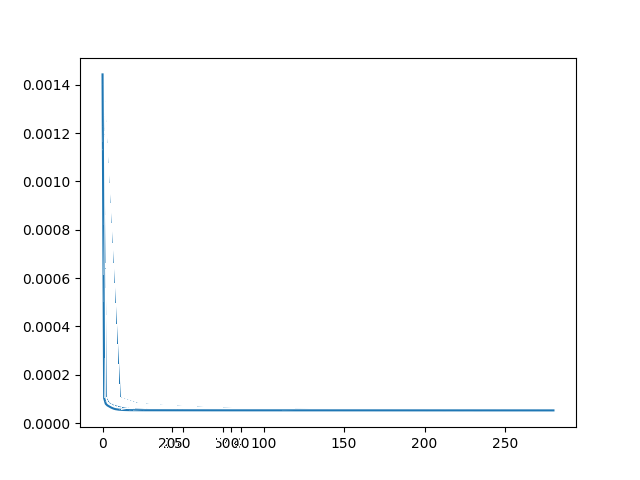

2022-01-15 14:38:07.244652: 1 loss: 0.0014425420789387854
2022-01-15 14:43:29.906420: 2 loss: 0.00010293028082905481
2022-01-15 15:27:58.643719: 11 loss: 5.547844636147112e-05
2022-01-15 16:26:02.209912: 21 loss: 5.3138043645398844e-05
2022-01-15 17:22:31.565169: 31 loss: 5.293571519050835e-05
2022-01-15 18:05:23.565516: 41 loss: 5.286214017803267e-05
2022-01-15 18:55:42.179740: 51 loss: 5.280311688110464e-05
2022-01-15 19:47:46.312958: 61 loss: 5.275191010229882e-05
2022-01-15 20:38:08.501565: 71 loss: 5.270626998201176e-05
2022-01-15 21:26:22.378547: 81 loss: 5.26699718997966e-05
2022-01-15 22:14:27.590536: 91 loss: 5.2639555623301974e-05
2022-01-15 23:11:00.383779: 101 loss: 5.2613339970519475e-05
2022-01-16 00:08:01.649741: 111 loss: 5.2588505140577654e-05
2022-01-16 01:02:08.118016: 121 loss: 5.256500952555143e-05
2022-01-16 01:52:31.593753: 131 loss: 5.254296462745072e-05
2022-01-16 03:32:18.279911: 151 loss: 5.250300799056836e-05
2022-01-16 04:22:33.261926: 161 loss: 5.248507198

In [ ]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import random

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
losses = []

for epoch in range(epochs_num):
    
    # training
    running_loss = 0.0
    training_accuracy = 0.0
    first = np.random.randint(0, len(ds) - training_size)
    batch_training_size= int(training_size / batch_size)
    for data, label in dataloader:
        output = model(data)

        loss = criterion(output, label)
        #print(f"label: {label.shape}")
        #print(f"outut: {output.shape}")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.data.item()
    losses.append(running_loss/batch_training_size)
    ax.clear()
    ax.plot(losses)
    fig.canvas.draw()
    ax.clear()
    ax.plot(losses)
    fig.canvas.draw()
    if epoch == 1 or epoch % 10 == 0:
        print(f'{datetime.datetime.now()}: {epoch + 1} loss: {running_loss/batch_training_size}')

In [199]:
torch.save(model.state_dict(), 'fx_DiffNextEMAs_LSTM_5_2days_mse_v1')

In [200]:
dummy_input, dummy_output = ds[0:1]
torch.onnx.export(model, dummy_input, 'fx_DiffNextEMAs_LSTM_5_2days_mse_v1.onnx')

In [188]:
dummy_input.shape

torch.Size([1, 577, 8])

In [114]:
val_ds = FXNextMEANDiffDataset(False)
val_dl = DataLoader(val_ds, batch_size = batch_size)

99926


In [119]:
%matplotlib notebook
def validate(model, val_loader):
    high_d = 0
    low_d = 0
    out_ = numpy.array([])
    ans_ = numpy.array([])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.ion()

    fig.show()
    fig.canvas.draw()
    losses = []

    for name, loader in [("val", val_loader)]:
        print(name)
        with torch.no_grad():
            correct = 0
            count = 0
            for values, anses in loader:
                outputs = model(values)
                ans = anses
                temp = outputs -ans
                high_d += temp.mean()
                out_ = numpy.append(out_, outputs.to('cpu').detach().numpy().copy())
                ans_ = numpy.append(ans_, ans.to('cpu').detach().numpy().copy())
                #high_rates = numpy.append(high_rates, rates[:,0].to('cpu').detach().numpy().copy())
                #low_rates = numpy.append(low_rates, rates[:,1].to('cpu').detach().numpy().copy())
                count += 1
    print('--------------------------------------------------')
    print(f'high: {high_d/count}')
    print(f'mean diff: {(ans_ - out_).mean()}, var: {(ans_ - out_).var()}')
    print('--------------------------------------------------')
    ax.clear()
    ax.plot(ans_,out_, 'ro', color="red")
    fig.canvas.draw()
    return ans_, out_

<IPython.core.display.Javascript object>


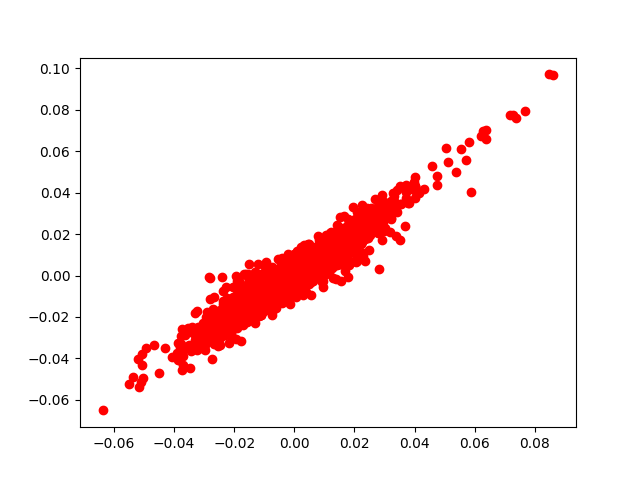

val
--------------------------------------------------
high: 0.00021814588399138302
mean diff: -0.00021747017712944475, var: 5.028660637701265e-06
--------------------------------------------------


In [120]:
ans, out = validate(model, val_dl)

In [137]:
len(ans)

29978

In [151]:
print(f"ans total: {len(ans)}")
print(f"valid: {numpy.count_nonzero(out[ans > 0] > 0) + numpy.count_nonzero(out[ans <= 0] <= 0)}")
print(f"positive false: {numpy.count_nonzero(out[ans > 0] <= 0)}")
print(f"negative false: {numpy.count_nonzero(out[ans <= 0] > 0)}")

ans total: 29978
valid: 26859
positive false: 1225
negative false: 1894
